In [1]:
import glob
import lxml
from attr import attrib
from lxml import etree
from lxml.etree import _Element
from sklearn.cluster import KMeans
from sklearn.cluster  import AgglomerativeClustering
import numpy as np
import math
from bs4 import BeautifulSoup
import tensorflow as tf
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [2]:
from layout_parser_2 import analysis
from visualizer import Visualizer
DOC_PATH = '/Users/trinhgiang/Downloads/Gold_Label'




[0.0015277792, 0.004196191, 0.06327111, 0.013802743, 0.11129558, 0.32298136]
False


In [3]:
import os
import subprocess
import sys
def _can_read(fpath: str) -> bool:
    return fpath.lower().endswith("pdf")

def _get_files(path):
    if os.path.isfile(path):
        fpaths = [path]
    elif os.path.isdir(path):
        fpaths = [os.path.join(path, f) for f in os.listdir(path)]
    else:
        fpaths = glob.glob(path)
    fpaths = [x for x in fpaths if _can_read(x)]
    if len(fpaths) > 0:
        return sorted(fpaths)
    else:
        raise IOError(f"File or directory not found: {path}")

In [4]:
files = _get_files(DOC_PATH)

In [ ]:
i = 1
file = files[i]

In [ ]:
%run layout_parser.py

In [ ]:
%run visualizer.py

## Tach line

In [ ]:
xml_content = subprocess.check_output(
    f"pdf2txt.py -t xml -M 3 -A '{file}' ", shell=True
)
soup = BeautifulSoup(xml_content, "lxml")
all_xml_elements = soup.find_all("pages")
if len(all_xml_elements) != 1:
    raise NotImplementedError(
        #f"unsupported format file: {file_name}"
    )
text = all_xml_elements[0]
tree = etree.fromstring(str(text))
tree = analysis(tree)
pars = tree.findall(".//paragraph")
for par in pars:
    t=""
    for line in par:
        for c in line:
            t+=c.text
    print(t)
    print("-------------------------------------")

In [5]:
def get_bbox(node: _Element):
    bbox = []
    if "bbox" not in node.keys():
        return bbox
    for i in node.attrib["bbox"].split(','):
        bbox.append(float(i))
    return bbox

In [6]:
def get_bbox_par(node: _Element):
    box = {
        "page": 0,
        "top": 0,
        "left": 0,
        "bottom":0,
        "right":0
    }
    page = int(node.getparent().attrib["id"])
    height = get_bbox(node.getparent())[3]
    box["page"] = page
    par_box = get_bbox(node)
    box["top"] = height - par_box[3]
    box["bottom"] = height - par_box[1]
    box["left"] = par_box[0]
    box["right"]= par_box[2]
    return box

In [7]:
def get_bbox_line(node: _Element):
    box = {
        "page": 0,
        "top": 0,
        "left": 0,
        "bottom":0,
        "right":0
    }
    page = int(node.getparent().getparent().attrib["id"])
    height = get_bbox(node.getparent().getparent())[3]
    box["page"] = page
    par_box = get_bbox(node)
    box["top"] = height - par_box[3]
    box["bottom"] = height - par_box[1]
    box["left"] = par_box[0]
    box["right"]= par_box[2]
    return box

In [ ]:
visualizer = Visualizer(DOC_PATH)
for i in [12]:
    file = '/Users/trinhgiang/Downloads/Gold_Label/Report2/71378-2016-Oanhnt-Ly lich khoa hoc.pdf'
    # file=files[183]
    xml_content = subprocess.check_output(
        f"pdf2txt.py -t xml -M 3 '{file}' ", shell=True
    )
    soup = BeautifulSoup(xml_content, "lxml")
    all_xml_elements = soup.find_all("pages")
    if len(all_xml_elements) != 1:
        raise NotImplementedError(
            #f"unsupported format file: {file_name}"
        )
    text = all_xml_elements[0]
    tree = etree.fromstring(str(text))
    tree = analysis(tree)
    pars = tree.findall(".//paragraph")
    par_boxs = []
    for par in pars:
        par_boxs.append(get_bbox_par(par))
    visualizer.display_paragraphs(par_boxs,file)


In [ ]:
from spacy_parser import Spacy
lingual_parser = Spacy("vi")

In [ ]:
lingual_parser.has_tokenizer_support()
lingual_parser.load_lang_model()

In [ ]:
parts = lingual_parser.split_sentences("I  always  seek  for  a  challenging  and  highly\n\
competitive  working  environment  which  can\n\
make use of and increasingly improve my English\n\
Skills,  technical  and  communication  skill.\n\
Besides,  my  foremost  objective  when  I  am\n\
working  in  a  company  is  to  contribute  to\n\
Part-time waiter\n\
its development and  help increase revenue for it\n\
Main responsibilities:\n\
and raise income for myself as well\n\
- Catered customers\n\
- Made orders for customers")

In [ ]:
for part in parts:
#     print(part)
    print(part["text"])
    print(len(part["text"]))
    print(part["words"])
    print(part["lenmas"])
#     print(len(part["words"][-1]))
#     print(part["char_offsets"])
#     print(part["char_offsets"][-1] + len(part["words"][-1]))
#     print(part["char_offsets"])
    print(part["abs_char_offsets"])
    print(part["ner_tags"])
    print(part["pos_tags"])

In [ ]:
    for i in range(1,len(part["char_offsets"])):
        part["char_offsets"][i] -= 1

In [ ]:
part["html"] =[]
for i in range(len(part["char_offsets"])):
    t =""
    for k,v in attrib[part["char_offsets"][i]].items():
        if k == "bbox":
            print(v)
#             v = v.replace(" ","")
#             t = t + k + "=" + v + " "
#     t=t[:-1]
#     part["html"].append(str(i)+r" : "+t)

In [ ]:
t = []
for k,v in attrib[0].items():
    if k != 'bbox':
        t.append(k+"="+v)

In [ ]:
part["html"]

In [ ]:
state = {
    "visited": set(),
    "parent": {},  # map of parent[child] = node used to discover child
    "context": {},  # track the Context of each node (context['td'] = Cell)
    "section": {"idx": 0},
    "paragraph": {"idx": 0},
    "figure": {"idx": 0},
    "caption": {"idx": 0},
    "table": {"idx": 0},
    "sentence": {"idx": 0, "abs_offset": 0},
}
abs_sentence_offset_end = (
state["sentence"]["abs_offset"]
+ part["char_offsets"][-1]
+ len(part["words"][-1])
)

In [ ]:
abs_sentence_offset_end

In [ ]:
for ancestor in tree.findall(".//textbox")[6][0].iterancestors():
    if ancestor.find("page") is not None:
        page = ancestor.find("page").get("id")
        bbox = ancestor.find("page").get("bbox")
        bbox = bbox.split(",")
        width = int(round(float(bbox[2])))
        height = bbox[3]

In [ ]:
print(page,width,height)

In [ ]:
attrib[0]["bbox"]

In [ ]:
part["html_attrs"]=[]
t = "aksjhdaksd"
part["html_attrs"].append(t)

In [ ]:
etree.strip_tags(tree,["textbox"])

In [ ]:
for layout in tree.findall(".//layout"):
    layout.getparent().remove(layout)

In [ ]:
text=lxml.etree.tostring(tree, encoding = "unicode")

In [ ]:
print(text)

In [ ]:
for i in tree:
    print(i)

In [ ]:
stack = []
stack.append(tree.getchildren()[0])

In [ ]:
stack

In [ ]:
print(etree.tostring(tree,encoding="unicode"))

In [ ]:
import re
VN_CHARS_LOWER = u'ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđð'
VN_CHARS_UPPER = u'ẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸÐĐ'
VN_CHARS = VN_CHARS_LOWER + VN_CHARS_UPPER
def no_marks(s):
    __INTAB = [ch for ch in VN_CHARS]
    __OUTTAB = "a"*17 + "o"*17 + "e"*11 + "u"*11 + "i"*5 + "y"*5 + "d"*2
    __OUTTAB += "A"*17 + "O"*17 + "E"*11 + "U"*11 + "I"*5 + "Y"*5 + "D"*2
    __r = re.compile("|".join(__INTAB))
    __replaces_dict = dict(zip(__INTAB, __OUTTAB))
    result = __r.sub(lambda m: __replaces_dict[m.group(0)], s)
    return result

In [ ]:
no_marks("Cường")

Số lượng thành viên  2 

[0.365039, 0.26519555, 0.0067139543, 0.19722351, 0.0005336571]
[0.40177065, 0.018096274, 0.66354907, 0.9967242, 0.87448215, 0.99848586, 0.9771155, 0.0001439936621833249, 0.14352167, 0.0013759831, 0.0060827187, 0.014812122, 0.6200403, 0.022670869]
[0.998868, 0.7331183, 0.900381, 0.2584087, 0.4874256, 0.36477372, 0.26468173, 0.6328032, 0.001569874, 0.05487472, 0.8880393, 0.92386174, 0.9397768592467597, 0.9545817, 0.978995224292916, 0.9310356]
[0.14871274, 0.98425853, 0.99997795, 0.033886958, 0.7267719, 0.06789906, 0.3551723, 0.08988501529196061, 0.44546777, 0.013226159, 0.0078631975, 0.019083405, 0.97527754, 0.99985397, 0.883304505249146, 0.99969053, 0.9985895120514072, 0.9894146, 0.5744375]
[9.992906e-05, 0.9799855975828983, 0.047295207875438804, 0.0023077459, 0.88868123, 0.019736834, 0.20732783, 0.120536804, 0.8920209, 0.82369334, 0.9442202, 0.9787618, 0.7624217, 0.89763, 0.005726479128403943]
[9.405729450975644e-05, 0.5359069, 0.0002732644649541645, 0.48242337

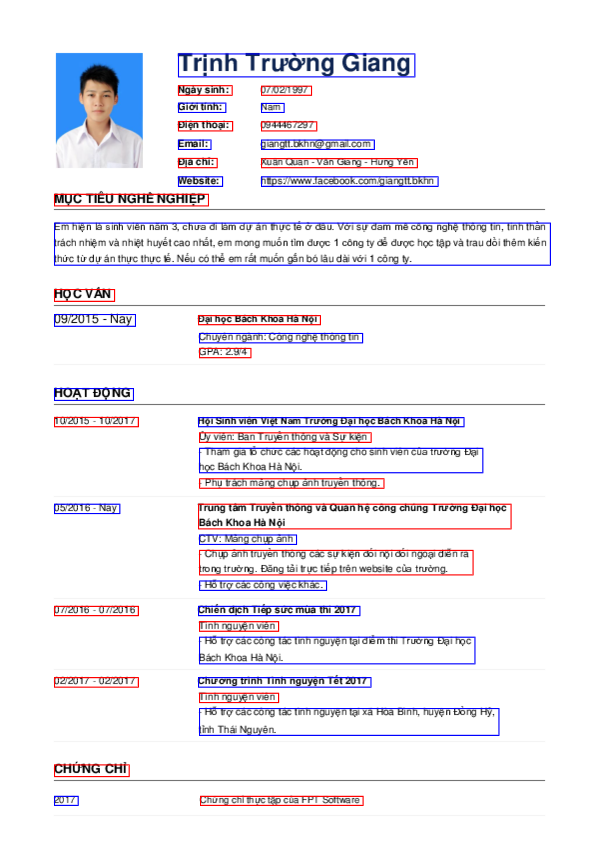

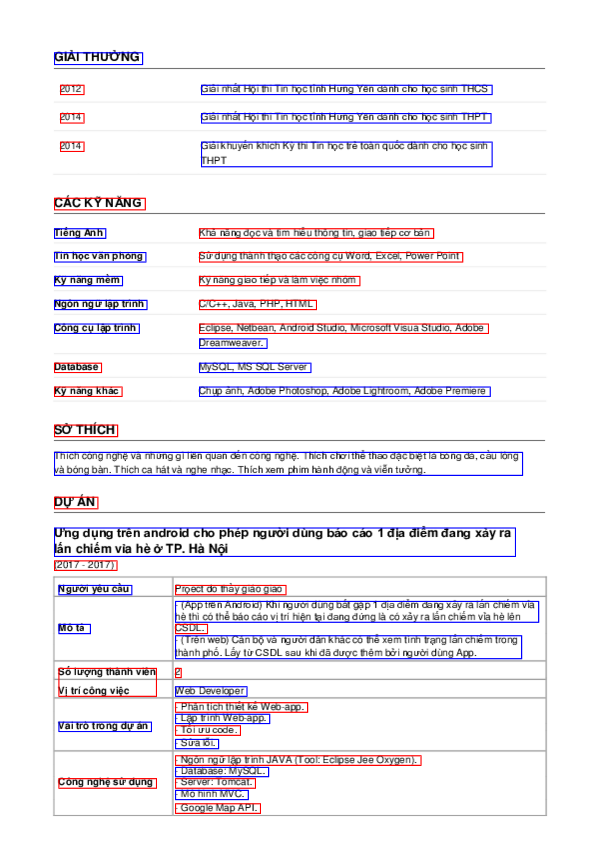

In [10]:
visualizer = Visualizer(DOC_PATH)
i=0
for file in [files[20]]:
    # file = files[183]
    name = 'cv'+str(i)
    file = '/Users/trinhgiang/Desktop/GiangTT/bo-nhan-dien/CV/Trinh-Truong-Giang-CV-Tieng-Viet.pdf'
    xml_content = subprocess.check_output(
        f"pdf2txt.py -t xml -M 3 '{file}' ", shell=True
    )
    soup = BeautifulSoup(xml_content, "lxml")
    all_xml_elements = soup.find_all("pages")
    if len(all_xml_elements) != 1:
        raise NotImplementedError(
            #f"unsupported format file: {file_name}"
        )
    text = all_xml_elements[0]
    tree = etree.fromstring(str(text))
    tree = analysis(tree)
    textlines = tree.findall(".//sentence")
    par_boxs = []
    for textline in textlines:
        par_boxs.append(get_bbox_line(textline))
    visualizer.display_paragraphs(par_boxs,name,file)
    i+=1


In [10]:
DOC_PATH = '/Users/trinhgiang/Downloads/Gold_Label/Report2'
files = _get_files(DOC_PATH)
visualizer = Visualizer(DOC_PATH)
for file in [files[0]]:
    # file = files[183]
    file = '/Users/trinhgiang/Downloads/Gold_Label/Report2/71378-2016-Oanhnt-Ly lich khoa hoc.pdf'
    xml_content = subprocess.check_output(
        f"pdf2txt.py -t xml -M 3 '{file}' ", shell=True
    )
    soup = BeautifulSoup(xml_content, "lxml")
    all_xml_elements = soup.find_all("pages")
    if len(all_xml_elements) != 1:
        raise NotImplementedError(
            #f"unsupported format file: {file_name}"
        )
    text = all_xml_elements[0]
    tree = etree.fromstring(str(text))
    tree = analysis(tree)
    textlines = tree.findall(".//sentence")
    par_boxs = []
    for textline in textlines:
        par_boxs.append(get_bbox_line(textline))
    visualizer.display_paragraphs(par_boxs,file)



Điện thoại:  09 43 20 65 66   

    quận Đống Đa, TP Hà nội 

Quốc gia  Học vị đạt 

1996  2001 

2001  2004 

2006  2009 

Trường  Đại  học 

Trường  Đại  học 

tâm  nghiên  cứu 

Việt Nam  Kỹ sư 

Việt Nam  Thạc sỹ 

<không  có 

<không  có 

Quốc gia  Kết quả 

-  Tiếng Anh: Đọc, viết: tốt; Nói: khá 

-  Pháp: Nghe nói đọc viết thành thạo 

Stt  Tên sách 

Nhà Xuất bản  Vai trò 

Năm  Giải 

Bậc  Vai trò  Năm 

Xây  dựng  ứng  dụng  tự 

Nguyễn  Thị 

Thạc  sỹ 

Ngô Thanh Tân  Thạc  sỹ 

Lê Hoài Nam  Thạc  sỹ 

Hoàng  Ngọc 

Thạc  sỹ 

Bùi Văn Thúc  Thạc  sỹ 

nghiệm  phát  hiện  mặt 

Trần  Thị  Hải 

Thạc  sỹ 

Hà nội, ngày        tháng  01    năm 2016 

[0.8887303, 0.4132079, 0.012386358, 0.00038020292, 1.176751e-05, 1.1113123e-05, 0.00026361365, 0.015611535]
[0.03836998, 0.9170663138855635, 0.9999473, 0.99960583, 0.0013254916998865188, 0.207591042201691, 0.9402771]
[0.09469656, 0.11931164, 0.008630442, 0.0009801575, 9.142386e-05]
[1.11429545e-05, 9.001041e-07]
[2.5596639e-05, 2.

TypeError: display_paragraphs() missing 1 required positional argument: 'pdf_file'